In [22]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #import Cllback function

import numpy as np
import matplotlib.pyplot as plt

In [7]:
data=r'D:/Safril/Dokumen/Pascasarjana/ITS/Semester 1/KBJ/FP/program/cnn-forgery/dataset/Train'

In [8]:
batch_size = 32
img_height = 224
img_width = 224

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(
                # rescale=1./255,
                # zoom_range=0.15, 
                # width_shift_range=0.2,
                # shear_range=0.15
                )
test_datagen = ImageDataGenerator()

In [10]:
#setting train test split
train = train_datagen.flow_from_directory(
        data,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        subset='training' )

test = test_datagen.flow_from_directory(
        data,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

Found 2208 images belonging to 2 classes.
Found 2208 images belonging to 2 classes.


In [11]:
classess = train.num_classes
classess

2

In [12]:
Mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3)) 

In [13]:
for i in Mobilenet.layers:
    i.trainable = False

In [14]:
def main_model(tl_model,classess):
    m_model=tl_model.output
    m_model=GlobalAveragePooling2D()(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dense(512,activation='relu')(m_model)
    m_model=Dense(classess,activation='softmax')(m_model)
    return m_model



In [15]:
combining_model=main_model(Mobilenet,classess)

In [16]:
model=Model(inputs=Mobilenet.input, outputs=combining_model)

In [17]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [23]:
earlystop=EarlyStopping(patience=10)#Monitor the performence. If it dips, then stop training
learning_rate_reduce= ReduceLROnPlateau(monitor='val_accuracy',min_lr=0.001)#Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

In [18]:
history=model.fit(train,validation_data=test,epochs=5)

Epoch 1/5
69/69 [==============================] - 173s 2s/step - loss: 0.3928 - accuracy: 0.8922 - val_loss: 0.3134 - val_accuracy: 0.8990
Epoch 2/5
69/69 [==============================] - 155s 2s/step - loss: 0.3211 - accuracy: 0.8990 - val_loss: 0.3024 - val_accuracy: 0.8990
Epoch 3/5
69/69 [==============================] - 150s 2s/step - loss: 0.3044 - accuracy: 0.8990 - val_loss: 0.2791 - val_accuracy: 0.8990
Epoch 4/5
69/69 [==============================] - 155s 2s/step - loss: 0.2980 - accuracy: 0.8990 - val_loss: 0.2694 - val_accuracy: 0.9004
Epoch 5/5
69/69 [==============================] - 151s 2s/step - loss: 0.2919 - accuracy: 0.8986 - val_loss: 0.2677 - val_accuracy: 0.9004


In [19]:
model.save('mobilenet_project.h5')

In [20]:
test_score=model.evaluate(test)

69/69 [==============================] - 72s 1s/step - loss: 0.2677 - accuracy: 0.9004


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

target_names=[]
for key in train.class_indices:
    target_names.append(key)

In [23]:
def plot_cfx(cm, classess, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks=np.arange(len(classess))
    plt.xticks(tick_marks, classess, rotation=45)
    plt.yticks(tick_marks, classess)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print('Confusion Matrix dengan Normalisasi')
    else:
        print('Confusion Matrix dengan Tanpa Normalisasi')
    thresh=cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
        

69/69 [==============================] - 76s 1s/step
confusion Matrix
Confusion Matrix dengan Tanpa Normalisasi


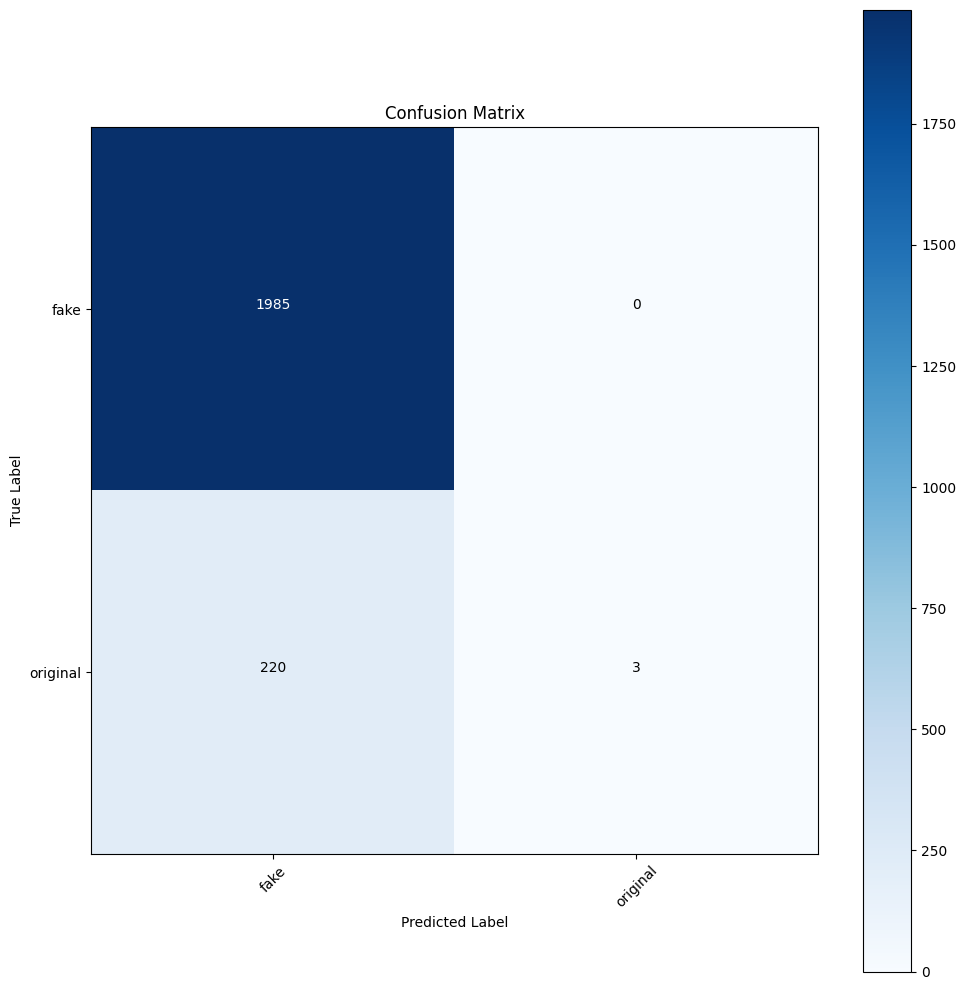

In [24]:
#Confusion Matrix dan Classification Report
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

plot_cfx(cm, target_names, title='Confusion Matrix')

In [25]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        fake       0.90      1.00      0.95      1985
    original       1.00      0.01      0.03       223

    accuracy                           0.90      2208
   macro avg       0.95      0.51      0.49      2208
weighted avg       0.91      0.90      0.85      2208



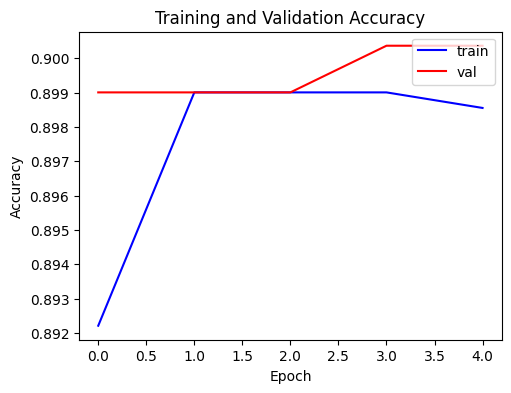

In [26]:
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
train_loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(train_accuracy))
plt.figure(figsize=(12,4))

#plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs,train_accuracy,'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy,'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'], loc='upper right')

#plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'b', label='Training Loss')
plt.plot(epochs,val_loss,'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper right')

plt.show()